In [1]:
import os
import sys
import time
import calendar
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy as sp
from scipy import stats
import tensorflow as tf

# from my_lib.field_config import data_encoder

# Setup

In [2]:
# ds_suffix = "vf10k"
ds_suffix = "-czech"
# max_seq_len = 80
# min_seq_len = 20

In [3]:

# gen_ds_file =  "generated_data/s-gen_num_layers_dec_4-d_model_128-num_heads_4-i_3-dr_0__1-dff_32-opt_adam-l_loss_mse_lwi-TC4X--vf1-len_40.csv"
# # gen_seq_len = 80
# gen_ds_file =  "generated_data/gen_num_layers_dec_4-d_model_128-num_heads_4-i_0-dr_0__1-dff_32-opt_adam-l_loss_mse_lwi-0--vf1-len_80.csv"

# fgen_file = "generated_data/f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv" 

gen_ds_file = "generated_data/h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv"
fgen_file = "generated_data/f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv"
tg_file = "generated_data/h-gtg_0-hd_24-nl_4-bs_32--len_80.csv"


gen_df = pd.read_csv(gen_ds_file, parse_dates=["date"])
gen_df["datetime"] = gen_df["date"]
gen_df

,Unnamed: 0,amount,k_symbol_num,operation_num,type_num,date_fields,days_passed,age,date,account_id,k_symbol,operation,type,tcode,datetime,raw_amount,raw_tcode
0,0,4716.28,0,0,0,01/31,0,47,1993-12-08,0,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,1993-12-08,4716.28,nan__CREDIT IN CASH__CREDIT
1,1,7273.42,0,0,0,01/31,4,47,1993-12-12,0,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,1993-12-12,7273.42,nan__CREDIT IN CASH__CREDIT
2,2,92.78,1,2,0,01/01,19,47,1993-12-31,0,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,1993-12-31,92.78,INTEREST CREDITED__nan__CREDIT
3,3,7178.21,0,0,0,01/31,8,47,1994-01-08,0,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,1994-01-08,7178.21,nan__CREDIT IN CASH__CREDIT
4,4,8915.65,0,0,0,01/31,3,47,1994-01-11,0,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,1994-01-11,8915.65,nan__CREDIT IN CASH__CREDIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,499975,5164.42,0,3,1,01/31,10,31,1998-11-15,4999,NaN,CASH WITHDRAWAL,DEBIT,nan__CASH WITHDRAWAL__DEBIT,1998-11-15,-5164.42,nan__CASH WITHDRAWAL__DEBIT
399996,499976,15233.14,0,0,0,01/31,3,31,1998-11-18,4999,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,1998-11-18,15233.14,nan__CREDIT IN CASH__CREDIT
399997,499977,7378.34,0,3,1,01/01,7,31,1998-11-25,4999,NaN,CASH WITHDRAWAL,DEBIT,nan__CASH WITHDRAWAL__DEBIT,1998-11-25,-7378.34,nan__CASH WITHDRAWAL__DEBIT
399998,499978,5054.12,0,3,1,01/01,1,31,1998-11-26,4999,NaN,CASH WITHDRAWAL,DEBIT,nan__CASH WITHDRAWAL__DEBIT,1998-11-26,-5054.12,nan__CASH WITHDRAWAL__DEBIT


In [4]:
real_df = pd.read_csv(f"real_data/final_df--czech.csv", parse_dates=["datetime"])
real_df["days_passed"] = real_df["td"]
real_df

,Unnamed: 0,Unnamed: 0.1,column_a,account_id,date,type,operation,amount,balance,k_symbol,...,datetime,month,day,dow,year,td,dtme,doy,raw_amount,days_passed
0,0,0,149432,1,950324,CREDIT,CREDIT IN CASH,1000.0,1000.0,NaN,...,1995-03-24,3,24,4,1995,0.0,7,83,1000.0,0.0
1,1,1,157404,1,950413,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,4679.0,NaN,...,1995-04-13,4,13,3,1995,20.0,17,103,3679.0,20.0
2,2,2,158832,1,950423,CREDIT,CREDIT IN CASH,12600.0,17279.0,NaN,...,1995-04-23,4,23,6,1995,10.0,7,113,12600.0,10.0
3,3,3,162681,1,950430,CREDIT,NaN,19.2,17298.2,INTEREST CREDITED,...,1995-04-30,4,30,6,1995,7.0,0,120,19.2,7.0
4,4,4,167083,1,950513,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,20977.2,NaN,...,1995-05-13,5,13,5,1995,13.0,18,133,3679.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,1056315,1056315,1033141,11382,981202,DEBIT,CASH WITHDRAWAL,25600.0,41114.4,NaN,...,1998-12-02,12,2,2,1998,2.0,29,336,-25600.0,2.0
1056316,1056316,1056316,1040574,11382,981210,CREDIT,COLLECTION FROM ANOTHER BANK,46248.0,87362.4,NaN,...,1998-12-10,12,10,3,1998,8.0,21,344,46248.0,8.0
1056317,1056317,1056317,1050362,11382,981225,DEBIT,CASH WITHDRAWAL,6300.0,81062.4,NaN,...,1998-12-25,12,25,4,1998,15.0,6,359,-6300.0,15.0
1056318,1056318,1056318,1053037,11382,981231,CREDIT,NaN,311.3,81373.6,INTEREST CREDITED,...,1998-12-31,12,31,3,1998,6.0,0,365,311.3,6.0


In [5]:
real_df.tcode = real_df.tcode.apply(lambda x: x.replace("$  $", "--"))

In [6]:
gen_df.tcode = gen_df.tcode.apply(lambda x: x.replace("$  $", "--"))

In [7]:


real_df["Amount"] = real_df.amount
real_df.amount = real_df.amount.apply(abs)


In [8]:
def describe(x):
    fns = ["mean", "median", "std", "min", "max"]
    for fn in fns:
        val = eval(f"np.{fn}(x)")
        print(f"{fn} is {val:.2f},", end="\t")
        
    fn = "log_abs_mean" 
    val = np.mean(np.log10(np.abs(x)+1.))
    print(f"{fn} is {val:.2f},")


In [9]:

fgen_df = pd.read_csv(fgen_file, parse_dates=["datetime"])
fgen_df["tcode"] = fgen_df.tcode.apply(lambda x: x.replace("---", "--"))
fgen_df.tcode.unique()

array(['nan__CREDIT IN CASH__CREDIT', 'nan__CASH WITHDRAWAL__DEBIT',
       'INTEREST CREDITED__nan__CREDIT',
       'HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT',
       'OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__CREDIT',
       'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT',
       ' __REMITTANCE TO ANOTHER BANK__DEBIT',
       'INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT',
       'nan__CREDIT CARD WITHDRAWAL__DEBIT',
       'nan__COLLECTION FROM ANOTHER BANK__CREDIT',
       'LOAN PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT',
       'nan__REMITTANCE TO ANOTHER BANK__DEBIT',
       'HOUSEHOLD__CASH WITHDRAWAL__DEBIT',
       'SANCTION INTEREST__CASH WITHDRAWAL__DEBIT',
       'INSURANCE PAYMENT__CASH WITHDRAWAL__DEBIT',
       ' __CASH WITHDRAWAL__DEBIT'], dtype=object)

In [10]:
fgen_df.columns

Index(['Unnamed: 0', 'unnamed: 0', 'tcode', 'amount', 'balance', 'age', 'dif',
       'account_id', 'date', 'date.1', 'cum_dif', 'days_passed', 'short_tcode',
       'raw_tcode', 'k_symbol', 'operation', 'type', 'datetime', 'raw_amount'],
      dtype='object')

In [11]:

tg_df = pd.read_csv(tg_file, parse_dates=['datetime'])
tg_df["days_passed"] = tg_df["td"]
# tg_df["tcode"] = fgen_df.tcode.apply(lambda x: x.replace("---", "--"))
tg_df

,k_symbol_num,operation_num,type_num,td,amount,age,account_id,datetime,k_symbol,operation,type,tcode,raw_amount,days_passed
0,0,2,0,4.0,104.25,44.0,0,1996-04-17,NaN,NaN,CREDIT,nan__nan__CREDIT,104.25,4.0
1,0,3,1,18.0,288.76,44.0,0,1996-05-05,NaN,CASH WITHDRAWAL,DEBIT,nan__CASH WITHDRAWAL__DEBIT,-288.76,18.0
2,1,2,0,4.0,81.29,44.0,0,1996-05-09,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,81.29,4.0
3,0,0,0,9.0,14286.56,44.0,0,1996-05-18,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,14286.56,9.0
4,0,4,1,-1.0,3936.29,44.0,0,1996-05-17,NaN,REMITTANCE TO ANOTHER BANK,DEBIT,nan__REMITTANCE TO ANOTHER BANK__DEBIT,-3936.29,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,1,2,0,15.0,100.05,44.0,4999,1997-05-27,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,100.05,15.0
399996,1,2,0,5.0,17.60,44.0,4999,1997-06-01,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,17.60,5.0
399997,2,3,1,2.0,0.24,44.0,4999,1997-06-03,PAYMENT ON STATEMENT,CASH WITHDRAWAL,DEBIT,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,-0.24,2.0
399998,1,3,0,2.0,0.41,44.0,4999,1997-06-05,INTEREST CREDITED,CASH WITHDRAWAL,CREDIT,INTEREST CREDITED__CASH WITHDRAWAL__CREDIT,0.41,2.0


# Look for regular things

In [17]:
accts_real = list(real_df.groupby("account_id"))

,Unnamed: 0,Unnamed: 0.1,column_a,account_id,date,type,operation,amount,balance,k_symbol,...,month,day,dow,year,td,dtme,doy,raw_amount,days_passed,Amount
0,0,0,149432,1,950324,CREDIT,CREDIT IN CASH,1000.0,1000.0,NaN,...,3,24,4,1995,0.0,7,83,1000.0,0.0,1000.0
1,1,1,157404,1,950413,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,4679.0,NaN,...,4,13,3,1995,20.0,17,103,3679.0,20.0,3679.0
2,2,2,158832,1,950423,CREDIT,CREDIT IN CASH,12600.0,17279.0,NaN,...,4,23,6,1995,10.0,7,113,12600.0,10.0,12600.0
3,3,3,162681,1,950430,CREDIT,NaN,19.2,17298.2,INTEREST CREDITED,...,4,30,6,1995,7.0,0,120,19.2,7.0,19.2
4,4,4,167083,1,950513,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,20977.2,NaN,...,5,13,5,1995,13.0,18,133,3679.0,13.0,3679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,234,234,1032336,1,981130,CREDIT,NaN,67.1,16701.5,INTEREST CREDITED,...,11,30,0,1998,0.0,0,334,67.1,0.0,67.1
235,235,235,1033713,1,981203,DEBIT,CASH WITHDRAWAL,4500.0,12186.9,NaN,...,12,3,3,1998,3.0,28,337,-4500.0,3.0,4500.0
236,236,236,1035097,1,981205,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,9734.9,HOUSEHOLD,...,12,5,5,1998,2.0,26,339,-2452.0,2.0,2452.0
237,237,237,1045493,1,981213,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,13413.9,NaN,...,12,13,6,1998,8.0,18,347,3679.0,8.0,3679.0


In [36]:
use_cols = ['account_id', 'type', 'operation', 'amount', 'k_symbol', 'age', 'tcode',
       'datetime', 'raw_amount', 'days_passed']

# balance

In [37]:
accts_real = [x[1][use_cols] for x in real_df.groupby("account_id")]

In [38]:
accts_bf = [x[1][use_cols] for x in gen_df.groupby("account_id")]
accts_tg = [x[1][use_cols] for x in tg_df.groupby("account_id")]
accts_dg = [x[1][use_cols] for x in fgen_df.groupby("account_id")]

# Inspect some accounts

In [39]:
accts_real[0].tcode.unique()

array(['nan__CREDIT IN CASH__CREDIT',
       'nan__COLLECTION FROM ANOTHER BANK__CREDIT',
       'INTEREST CREDITED__nan__CREDIT', 'nan__CASH WITHDRAWAL__DEBIT',
       'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT',
       'HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT'], dtype=object)

In [40]:
acct.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'column_a', 'account_id', 'date', 'type',
       'operation', 'amount', 'balance', 'k_symbol', 'age', 'tcode',
       'datetime', 'month', 'day', 'dow', 'year', 'td', 'dtme', 'doy',
       'raw_amount', 'days_passed', 'Amount'],
      dtype='object')

#### real acct

In [49]:
dict(acct[acct.tcode==tcode].describe()["amount"])["std"]

0.0

In [54]:

acct = accts_real[0]

stdevs_r = {}

for tcode in acct.tcode.unique():
    
    print(tcode)
    display(acct[acct.tcode==tcode])
    print("\n")
    display(acct[acct.tcode==tcode].describe()["amount"])
    print("\n\n")
    
    stdevs_r[tcode] = dict(acct[acct.tcode==tcode].describe()["amount"])["std"]
    
    
    
print("\n\nAll stdevs:\n")
stdevs_r

nan__CREDIT IN CASH__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
0,1,CREDIT,CREDIT IN CASH,1000.0,NaN,29,nan__CREDIT IN CASH__CREDIT,1995-03-24,1000.0,0.0
2,1,CREDIT,CREDIT IN CASH,12600.0,NaN,29,nan__CREDIT IN CASH__CREDIT,1995-04-23,12600.0,10.0
5,1,CREDIT,CREDIT IN CASH,2100.0,NaN,29,nan__CREDIT IN CASH__CREDIT,1995-05-23,2100.0,10.0
53,1,CREDIT,CREDIT IN CASH,100.0,NaN,29,nan__CREDIT IN CASH__CREDIT,1996-02-17,100.0,4.0
58,1,CREDIT,CREDIT IN CASH,200.0,NaN,29,nan__CREDIT IN CASH__CREDIT,1996-03-18,200.0,5.0
74,1,CREDIT,CREDIT IN CASH,1400.0,NaN,29,nan__CREDIT IN CASH__CREDIT,1996-06-16,1400.0,3.0
81,1,CREDIT,CREDIT IN CASH,1000.0,NaN,29,nan__CREDIT IN CASH__CREDIT,1996-07-16,1000.0,0.0
87,1,CREDIT,CREDIT IN CASH,2400.0,NaN,29,nan__CREDIT IN CASH__CREDIT,1996-08-15,2400.0,2.0
114,1,CREDIT,CREDIT IN CASH,1200.0,NaN,29,nan__CREDIT IN CASH__CREDIT,1997-01-12,1200.0,7.0
123,1,CREDIT,CREDIT IN CASH,1700.0,NaN,29,nan__CREDIT IN CASH__CREDIT,1997-02-11,1700.0,6.0


count       12.000000
mean      2141.666667
std       3367.345416
min        100.000000
25%        875.000000
50%       1300.000000
75%       1800.000000
max      12600.000000
Name: amount, dtype: float64




nan__COLLECTION FROM ANOTHER BANK__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
1,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,NaN,29,nan__COLLECTION FROM ANOTHER BANK__CREDIT,1995-04-13,3679.0,20.0
4,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,NaN,29,nan__COLLECTION FROM ANOTHER BANK__CREDIT,1995-05-13,3679.0,13.0
7,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,NaN,29,nan__COLLECTION FROM ANOTHER BANK__CREDIT,1995-06-13,3679.0,13.0
10,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,NaN,29,nan__COLLECTION FROM ANOTHER BANK__CREDIT,1995-07-13,3679.0,13.0
13,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,NaN,29,nan__COLLECTION FROM ANOTHER BANK__CREDIT,1995-08-13,3679.0,13.0
18,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,NaN,29,nan__COLLECTION FROM ANOTHER BANK__CREDIT,1995-09-13,3679.0,8.0
23,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,NaN,29,nan__COLLECTION FROM ANOTHER BANK__CREDIT,1995-10-13,3679.0,8.0
28,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,NaN,29,nan__COLLECTION FROM ANOTHER BANK__CREDIT,1995-11-13,3679.0,8.0
34,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,NaN,29,nan__COLLECTION FROM ANOTHER BANK__CREDIT,1995-12-13,3679.0,8.0
44,1,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,NaN,29,nan__COLLECTION FROM ANOTHER BANK__CREDIT,1996-01-13,3679.0,3.0


count      45.0
mean     3679.0
std         0.0
min      3679.0
25%      3679.0
50%      3679.0
75%      3679.0
max      3679.0
Name: amount, dtype: float64




INTEREST CREDITED__nan__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
3,1,CREDIT,NaN,19.2,INTEREST CREDITED,29,INTEREST CREDITED__nan__CREDIT,1995-04-30,19.2,7.0
6,1,CREDIT,NaN,79.0,INTEREST CREDITED,29,INTEREST CREDITED__nan__CREDIT,1995-05-31,79.0,8.0
9,1,CREDIT,NaN,100.6,INTEREST CREDITED,29,INTEREST CREDITED__nan__CREDIT,1995-06-30,100.6,8.0
12,1,CREDIT,NaN,108.9,INTEREST CREDITED,29,INTEREST CREDITED__nan__CREDIT,1995-07-31,108.9,9.0
16,1,CREDIT,NaN,99.2,INTEREST CREDITED,29,INTEREST CREDITED__nan__CREDIT,1995-08-31,99.2,0.0
21,1,CREDIT,NaN,91.5,INTEREST CREDITED,29,INTEREST CREDITED__nan__CREDIT,1995-09-30,91.5,0.0
26,1,CREDIT,NaN,90.5,INTEREST CREDITED,29,INTEREST CREDITED__nan__CREDIT,1995-10-31,90.5,0.0
32,1,CREDIT,NaN,85.2,INTEREST CREDITED,29,INTEREST CREDITED__nan__CREDIT,1995-11-30,85.2,0.0
38,1,CREDIT,NaN,79.0,INTEREST CREDITED,29,INTEREST CREDITED__nan__CREDIT,1995-12-31,79.0,0.0
50,1,CREDIT,NaN,64.1,INTEREST CREDITED,29,INTEREST CREDITED__nan__CREDIT,1996-01-31,64.1,0.0


count     45.000000
mean      68.122222
std       15.309740
min       19.200000
25%       59.200000
50%       65.700000
75%       75.400000
max      108.900000
Name: amount, dtype: float64




nan__CASH WITHDRAWAL__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
8,1,DEBIT,CASH WITHDRAWAL,200.0,NaN,29,nan__CASH WITHDRAWAL__DEBIT,1995-06-22,-200.0,9.0
11,1,DEBIT,CASH WITHDRAWAL,5300.0,NaN,29,nan__CASH WITHDRAWAL__DEBIT,1995-07-22,-5300.0,9.0
14,1,DEBIT,CASH WITHDRAWAL,7500.0,NaN,29,nan__CASH WITHDRAWAL__DEBIT,1995-08-21,-7500.0,8.0
19,1,DEBIT,CASH WITHDRAWAL,700.0,NaN,29,nan__CASH WITHDRAWAL__DEBIT,1995-09-20,-700.0,7.0
24,1,DEBIT,CASH WITHDRAWAL,2900.0,NaN,29,nan__CASH WITHDRAWAL__DEBIT,1995-10-20,-2900.0,7.0
29,1,DEBIT,CASH WITHDRAWAL,1900.0,NaN,29,nan__CASH WITHDRAWAL__DEBIT,1995-11-19,-1900.0,6.0
31,1,DEBIT,CASH WITHDRAWAL,870.0,NaN,29,nan__CASH WITHDRAWAL__DEBIT,1995-11-30,-870.0,0.0
35,1,DEBIT,CASH WITHDRAWAL,1600.0,NaN,29,nan__CASH WITHDRAWAL__DEBIT,1995-12-19,-1600.0,6.0
36,1,DEBIT,CASH WITHDRAWAL,540.0,NaN,29,nan__CASH WITHDRAWAL__DEBIT,1995-12-24,-540.0,5.0
39,1,DEBIT,CASH WITHDRAWAL,210.0,NaN,29,nan__CASH WITHDRAWAL__DEBIT,1996-01-04,-210.0,4.0


count      57.000000
mean     1441.929825
std      1663.501512
min       100.000000
25%       420.000000
50%       810.000000
75%      1700.000000
max      7500.000000
Name: amount, dtype: float64




PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
15,1,DEBIT,CASH WITHDRAWAL,14.6,PAYMENT ON STATEMENT,29,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1995-08-31,-14.6,10.0
20,1,DEBIT,CASH WITHDRAWAL,14.6,PAYMENT ON STATEMENT,29,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1995-09-30,-14.6,10.0
25,1,DEBIT,CASH WITHDRAWAL,14.6,PAYMENT ON STATEMENT,29,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1995-10-31,-14.6,11.0
30,1,DEBIT,CASH WITHDRAWAL,14.6,PAYMENT ON STATEMENT,29,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1995-11-30,-14.6,11.0
37,1,DEBIT,CASH WITHDRAWAL,14.6,PAYMENT ON STATEMENT,29,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1995-12-31,-14.6,7.0
49,1,DEBIT,CASH WITHDRAWAL,14.6,PAYMENT ON STATEMENT,29,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1996-01-31,-14.6,4.0
54,1,DEBIT,CASH WITHDRAWAL,14.6,PAYMENT ON STATEMENT,29,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1996-02-29,-14.6,12.0
59,1,DEBIT,CASH WITHDRAWAL,14.6,PAYMENT ON STATEMENT,29,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1996-03-31,-14.6,13.0
64,1,DEBIT,CASH WITHDRAWAL,14.6,PAYMENT ON STATEMENT,29,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1996-04-30,-14.6,13.0
70,1,DEBIT,CASH WITHDRAWAL,14.6,PAYMENT ON STATEMENT,29,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1996-05-31,-14.6,14.0


count    4.000000e+01
mean     1.460000e+01
std      1.259291e-14
min      1.460000e+01
25%      1.460000e+01
50%      1.460000e+01
75%      1.460000e+01
max      1.460000e+01
Name: amount, dtype: float64




HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
17,1,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,HOUSEHOLD,29,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1995-09-05,-2452.0,5.0
22,1,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,HOUSEHOLD,29,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1995-10-05,-2452.0,5.0
27,1,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,HOUSEHOLD,29,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1995-11-05,-2452.0,5.0
33,1,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,HOUSEHOLD,29,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1995-12-05,-2452.0,5.0
40,1,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,HOUSEHOLD,29,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-01-05,-2452.0,1.0
51,1,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,HOUSEHOLD,29,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-02-05,-2452.0,5.0
56,1,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,HOUSEHOLD,29,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-03-05,-2452.0,5.0
61,1,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,HOUSEHOLD,29,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-04-05,-2452.0,5.0
66,1,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,HOUSEHOLD,29,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-05-05,-2452.0,5.0
72,1,DEBIT,REMITTANCE TO ANOTHER BANK,2452.0,HOUSEHOLD,29,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-06-05,-2452.0,5.0


count      40.0
mean     2452.0
std         0.0
min      2452.0
25%      2452.0
50%      2452.0
75%      2452.0
max      2452.0
Name: amount, dtype: float64






All stdevs:



{'nan__CREDIT IN CASH__CREDIT': 3367.3454161275395,
 'nan__COLLECTION FROM ANOTHER BANK__CREDIT': 0.0,
 'INTEREST CREDITED__nan__CREDIT': 15.309739753278999,
 'nan__CASH WITHDRAWAL__DEBIT': 1663.501512082798,
 'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT': 1.2592905508742665e-14,
 'HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT': 0.0}

In [55]:
acct[acct.tcode==tcode].describe()["amount"]

count      40.0
mean     2452.0
std         0.0
min      2452.0
25%      2452.0
50%      2452.0
75%      2452.0
max      2452.0
Name: amount, dtype: float64

#### bf acct

In [56]:

acct = accts_bf[0]

stdevs_bf = {}

for tcode in acct.tcode.unique():
    
    print(tcode)
    display(acct[acct.tcode==tcode])
    print("\n")
    display(acct[acct.tcode==tcode].describe()["amount"])
    print("\n\n")
    
    stdevs_bf[tcode] = dict(acct[acct.tcode==tcode].describe()["amount"])["std"]
    
    
    
print("\n\nAll stdevs:\n")
stdevs_bf

nan__CREDIT IN CASH__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
0,0,CREDIT,CREDIT IN CASH,4716.28,NaN,47,nan__CREDIT IN CASH__CREDIT,1993-12-08,4716.28,0
1,0,CREDIT,CREDIT IN CASH,7273.42,NaN,47,nan__CREDIT IN CASH__CREDIT,1993-12-12,7273.42,4
3,0,CREDIT,CREDIT IN CASH,7178.21,NaN,47,nan__CREDIT IN CASH__CREDIT,1994-01-08,7178.21,8
4,0,CREDIT,CREDIT IN CASH,8915.65,NaN,47,nan__CREDIT IN CASH__CREDIT,1994-01-11,8915.65,3
7,0,CREDIT,CREDIT IN CASH,16364.82,NaN,47,nan__CREDIT IN CASH__CREDIT,1994-02-10,16364.82,2
10,0,CREDIT,CREDIT IN CASH,13128.67,NaN,47,nan__CREDIT IN CASH__CREDIT,1994-03-11,13128.67,3
13,0,CREDIT,CREDIT IN CASH,12815.28,NaN,47,nan__CREDIT IN CASH__CREDIT,1994-04-09,12815.28,2
18,0,CREDIT,CREDIT IN CASH,8809.87,NaN,47,nan__CREDIT IN CASH__CREDIT,1994-05-08,8809.87,0
20,0,CREDIT,CREDIT IN CASH,14960.36,NaN,47,nan__CREDIT IN CASH__CREDIT,1994-05-10,14960.36,1
26,0,CREDIT,CREDIT IN CASH,8724.75,NaN,47,nan__CREDIT IN CASH__CREDIT,1994-06-08,8724.75,1


count       20.000000
mean     10703.506500
std       3837.055621
min       4716.280000
25%       7249.617500
50%      10065.755000
75%      14099.795000
max      16644.240000
Name: amount, dtype: float64




INTEREST CREDITED__nan__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
2,0,CREDIT,NaN,92.78,INTEREST CREDITED,47,INTEREST CREDITED__nan__CREDIT,1993-12-31,92.78,19
5,0,CREDIT,NaN,104.65,INTEREST CREDITED,47,INTEREST CREDITED__nan__CREDIT,1994-01-31,104.65,20
8,0,CREDIT,NaN,142.44,INTEREST CREDITED,47,INTEREST CREDITED__nan__CREDIT,1994-02-28,142.44,18
11,0,CREDIT,NaN,166.15,INTEREST CREDITED,47,INTEREST CREDITED__nan__CREDIT,1994-03-31,166.15,20
14,0,CREDIT,NaN,87.33,INTEREST CREDITED,47,INTEREST CREDITED__nan__CREDIT,1994-04-30,87.33,21
21,0,CREDIT,NaN,185.47,INTEREST CREDITED,47,INTEREST CREDITED__nan__CREDIT,1994-05-31,185.47,21
28,0,CREDIT,NaN,185.73,INTEREST CREDITED,47,INTEREST CREDITED__nan__CREDIT,1994-06-30,185.73,19
33,0,CREDIT,NaN,113.38,INTEREST CREDITED,47,INTEREST CREDITED__nan__CREDIT,1994-07-31,113.38,20
39,0,CREDIT,NaN,166.77,INTEREST CREDITED,47,INTEREST CREDITED__nan__CREDIT,1994-08-31,166.77,20
45,0,CREDIT,NaN,150.04,INTEREST CREDITED,47,INTEREST CREDITED__nan__CREDIT,1994-09-30,150.04,19


count     14.000000
mean     141.992143
std       35.635574
min       87.330000
25%      111.197500
50%      146.240000
75%      172.732500
max      185.730000
Name: amount, dtype: float64




nan__CASH WITHDRAWAL__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
6,0,DEBIT,CASH WITHDRAWAL,4218.01,NaN,47,nan__CASH WITHDRAWAL__DEBIT,1994-02-08,-4218.01,8
9,0,DEBIT,CASH WITHDRAWAL,9184.05,NaN,47,nan__CASH WITHDRAWAL__DEBIT,1994-03-08,-9184.05,8
12,0,DEBIT,CASH WITHDRAWAL,9992.94,NaN,47,nan__CASH WITHDRAWAL__DEBIT,1994-04-07,-9992.94,7
17,0,DEBIT,CASH WITHDRAWAL,5654.13,NaN,47,nan__CASH WITHDRAWAL__DEBIT,1994-05-08,-5654.13,2
19,0,DEBIT,CASH WITHDRAWAL,5601.93,NaN,47,nan__CASH WITHDRAWAL__DEBIT,1994-05-09,-5601.93,1
23,0,DEBIT,CASH WITHDRAWAL,7261.87,NaN,47,nan__CASH WITHDRAWAL__DEBIT,1994-06-01,-7261.87,1
25,0,DEBIT,CASH WITHDRAWAL,4174.49,NaN,47,nan__CASH WITHDRAWAL__DEBIT,1994-06-07,-4174.49,1
31,0,DEBIT,CASH WITHDRAWAL,6555.05,NaN,47,nan__CASH WITHDRAWAL__DEBIT,1994-07-08,-6555.05,2
35,0,DEBIT,CASH WITHDRAWAL,8915.77,NaN,47,nan__CASH WITHDRAWAL__DEBIT,1994-08-04,-8915.77,4
41,0,DEBIT,CASH WITHDRAWAL,7317.62,NaN,47,nan__CASH WITHDRAWAL__DEBIT,1994-09-04,-7317.62,4


count      26.000000
mean     6091.430769
std      1900.003044
min      2991.070000
25%      4371.807500
50%      5970.010000
75%      7294.370000
max      9992.940000
Name: amount, dtype: float64




PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
15,0,DEBIT,CASH WITHDRAWAL,38.27,PAYMENT ON STATEMENT,47,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1994-04-30,-38.27,0
22,0,DEBIT,CASH WITHDRAWAL,14.92,PAYMENT ON STATEMENT,47,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1994-05-31,-14.92,0
29,0,DEBIT,CASH WITHDRAWAL,15.34,PAYMENT ON STATEMENT,47,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1994-06-30,-15.34,0
34,0,DEBIT,CASH WITHDRAWAL,17.72,PAYMENT ON STATEMENT,47,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1994-07-31,-17.72,0
40,0,DEBIT,CASH WITHDRAWAL,13.10,PAYMENT ON STATEMENT,47,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1994-08-31,-13.10,0
46,0,DEBIT,CASH WITHDRAWAL,15.84,PAYMENT ON STATEMENT,47,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1994-09-30,-15.84,0
51,0,DEBIT,CASH WITHDRAWAL,13.67,PAYMENT ON STATEMENT,47,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1994-10-31,-13.67,0
57,0,DEBIT,CASH WITHDRAWAL,12.25,PAYMENT ON STATEMENT,47,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1994-11-30,-12.25,0
65,0,DEBIT,CASH WITHDRAWAL,19.46,PAYMENT ON STATEMENT,47,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1994-12-31,-19.46,0
73,0,DEBIT,CASH WITHDRAWAL,16.16,PAYMENT ON STATEMENT,47,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1995-01-31,-16.16,0


count    10.000000
mean     17.673000
std       7.545773
min      12.250000
25%      13.982500
50%      15.590000
75%      17.330000
max      38.270000
Name: amount, dtype: float64




INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
16,0,DEBIT,REMITTANCE TO ANOTHER BANK,751.09,INSURANCE PAYMENT,47,INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK_...,1994-05-06,-751.09,6
24,0,DEBIT,REMITTANCE TO ANOTHER BANK,856.60,INSURANCE PAYMENT,47,INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK_...,1994-06-06,-856.60,5
30,0,DEBIT,REMITTANCE TO ANOTHER BANK,713.58,INSURANCE PAYMENT,47,INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK_...,1994-07-06,-713.58,6
36,0,DEBIT,REMITTANCE TO ANOTHER BANK,835.60,INSURANCE PAYMENT,47,INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK_...,1994-08-06,-835.60,2
42,0,DEBIT,REMITTANCE TO ANOTHER BANK,683.38,INSURANCE PAYMENT,47,INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK_...,1994-09-07,-683.38,3
48,0,DEBIT,REMITTANCE TO ANOTHER BANK,804.19,INSURANCE PAYMENT,47,INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK_...,1994-10-06,-804.19,2
53,0,DEBIT,REMITTANCE TO ANOTHER BANK,650.12,INSURANCE PAYMENT,47,INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK_...,1994-11-05,-650.12,1
59,0,DEBIT,REMITTANCE TO ANOTHER BANK,897.78,INSURANCE PAYMENT,47,INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK_...,1994-12-05,-897.78,3
70,0,DEBIT,REMITTANCE TO ANOTHER BANK,755.62,INSURANCE PAYMENT,47,INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK_...,1995-01-07,-755.62,1
75,0,DEBIT,REMITTANCE TO ANOTHER BANK,800.38,INSURANCE PAYMENT,47,INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK_...,1995-02-05,-800.38,4


count     10.000000
mean     774.834000
std       78.606404
min      650.120000
25%      722.957500
50%      778.000000
75%      827.747500
max      897.780000
Name: amount, dtype: float64






All stdevs:



{'nan__CREDIT IN CASH__CREDIT': 3837.0556211313287,
 'INTEREST CREDITED__nan__CREDIT': 35.63557431266412,
 'nan__CASH WITHDRAWAL__DEBIT': 1900.0030436079267,
 'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT': 7.5457729888991505,
 'INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT': 78.60640420616008}

#### tg acct

In [57]:

acct = accts_tg[0]

stdevs_tg = {}

for tcode in acct.tcode.unique():
    
    print(tcode)
    display(acct[acct.tcode==tcode])
    print("\n")
    display(acct[acct.tcode==tcode].describe()["amount"])
    print("\n\n")
    
    stdevs_tg[tcode] = dict(acct[acct.tcode==tcode].describe()["amount"])["std"]
    
    
    
print("\n\nAll stdevs:\n")
stdevs_tg

nan__nan__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
0,0,CREDIT,NaN,104.25,NaN,44.0,nan__nan__CREDIT,1996-04-17,104.25,4.0


count      1.00
mean     104.25
std         NaN
min      104.25
25%      104.25
50%      104.25
75%      104.25
max      104.25
Name: amount, dtype: float64




nan__CASH WITHDRAWAL__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
1,0,DEBIT,CASH WITHDRAWAL,288.76,NaN,44.0,nan__CASH WITHDRAWAL__DEBIT,1996-05-05,-288.76,18.0
9,0,DEBIT,CASH WITHDRAWAL,8719.02,NaN,44.0,nan__CASH WITHDRAWAL__DEBIT,1996-06-11,-8719.02,0.0
11,0,DEBIT,CASH WITHDRAWAL,3256.74,NaN,44.0,nan__CASH WITHDRAWAL__DEBIT,1996-06-20,-3256.74,0.0
15,0,DEBIT,CASH WITHDRAWAL,1773.00,NaN,44.0,nan__CASH WITHDRAWAL__DEBIT,1996-07-19,-1773.00,18.0
21,0,DEBIT,CASH WITHDRAWAL,573.26,NaN,44.0,nan__CASH WITHDRAWAL__DEBIT,1996-09-05,-573.26,12.0
27,0,DEBIT,CASH WITHDRAWAL,2865.21,NaN,44.0,nan__CASH WITHDRAWAL__DEBIT,1996-09-27,-2865.21,0.0
29,0,DEBIT,CASH WITHDRAWAL,2811.45,NaN,44.0,nan__CASH WITHDRAWAL__DEBIT,1996-09-27,-2811.45,-1.0
31,0,DEBIT,CASH WITHDRAWAL,11291.36,NaN,44.0,nan__CASH WITHDRAWAL__DEBIT,1996-10-10,-11291.36,-0.0
41,0,DEBIT,CASH WITHDRAWAL,17950.32,NaN,44.0,nan__CASH WITHDRAWAL__DEBIT,1996-11-24,-17950.32,6.0
46,0,DEBIT,CASH WITHDRAWAL,10428.81,NaN,44.0,nan__CASH WITHDRAWAL__DEBIT,1996-12-19,-10428.81,1.0


count       15.000000
mean      6417.534000
std       5059.855378
min        288.760000
25%       2292.225000
50%       7515.010000
75%       9573.915000
max      17950.320000
Name: amount, dtype: float64




INTEREST CREDITED__nan__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
2,0,CREDIT,NaN,81.29,INTEREST CREDITED,44.0,INTEREST CREDITED__nan__CREDIT,1996-05-09,81.29,4.0
12,0,CREDIT,NaN,136.87,INTEREST CREDITED,44.0,INTEREST CREDITED__nan__CREDIT,1996-07-01,136.87,11.0
13,0,CREDIT,NaN,40.15,INTEREST CREDITED,44.0,INTEREST CREDITED__nan__CREDIT,1996-06-29,40.15,-2.0
20,0,CREDIT,NaN,91.27,INTEREST CREDITED,44.0,INTEREST CREDITED__nan__CREDIT,1996-08-24,91.27,12.0
23,0,CREDIT,NaN,55.83,INTEREST CREDITED,44.0,INTEREST CREDITED__nan__CREDIT,1996-09-13,55.83,-3.0
32,0,CREDIT,NaN,132.32,INTEREST CREDITED,44.0,INTEREST CREDITED__nan__CREDIT,1996-10-24,132.32,14.0
33,0,CREDIT,NaN,45.15,INTEREST CREDITED,44.0,INTEREST CREDITED__nan__CREDIT,1996-10-22,45.15,-2.0
42,0,CREDIT,NaN,114.31,INTEREST CREDITED,44.0,INTEREST CREDITED__nan__CREDIT,1996-12-08,114.31,14.0
43,0,CREDIT,NaN,43.03,INTEREST CREDITED,44.0,INTEREST CREDITED__nan__CREDIT,1996-12-06,43.03,-2.0
53,0,CREDIT,NaN,119.88,INTEREST CREDITED,44.0,INTEREST CREDITED__nan__CREDIT,1997-01-16,119.88,17.0


count     19.000000
mean      62.804211
std       43.961127
min        4.890000
25%       27.805000
50%       45.150000
75%       97.025000
max      136.870000
Name: amount, dtype: float64




nan__CREDIT IN CASH__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
3,0,CREDIT,CREDIT IN CASH,14286.56,NaN,44.0,nan__CREDIT IN CASH__CREDIT,1996-05-18,14286.56,9.0
6,0,CREDIT,CREDIT IN CASH,15738.85,NaN,44.0,nan__CREDIT IN CASH__CREDIT,1996-06-04,15738.85,14.0
8,0,CREDIT,CREDIT IN CASH,13387.20,NaN,44.0,nan__CREDIT IN CASH__CREDIT,1996-06-11,13387.20,8.0
10,0,CREDIT,CREDIT IN CASH,24444.74,NaN,44.0,nan__CREDIT IN CASH__CREDIT,1996-06-20,24444.74,9.0
14,0,CREDIT,CREDIT IN CASH,10435.53,NaN,44.0,nan__CREDIT IN CASH__CREDIT,1996-07-01,10435.53,2.0
18,0,CREDIT,CREDIT IN CASH,9015.35,NaN,44.0,nan__CREDIT IN CASH__CREDIT,1996-08-08,9015.35,4.0
24,0,CREDIT,CREDIT IN CASH,12485.48,NaN,44.0,nan__CREDIT IN CASH__CREDIT,1996-09-20,12485.48,7.0
30,0,CREDIT,CREDIT IN CASH,15448.68,NaN,44.0,nan__CREDIT IN CASH__CREDIT,1996-10-10,15448.68,13.0
36,0,CREDIT,CREDIT IN CASH,12286.44,NaN,44.0,nan__CREDIT IN CASH__CREDIT,1996-11-05,12286.44,7.0
37,0,CREDIT,CREDIT IN CASH,13014.00,NaN,44.0,nan__CREDIT IN CASH__CREDIT,1996-11-12,13014.00,7.0


count       17.000000
mean     13712.058235
std       4125.617269
min       9015.350000
25%      11030.330000
50%      12485.480000
75%      15448.680000
max      24444.740000
Name: amount, dtype: float64




nan__REMITTANCE TO ANOTHER BANK__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
4,0,DEBIT,REMITTANCE TO ANOTHER BANK,3936.29,NaN,44.0,nan__REMITTANCE TO ANOTHER BANK__DEBIT,1996-05-17,-3936.29,-1.0
34,0,DEBIT,REMITTANCE TO ANOTHER BANK,2870.94,NaN,44.0,nan__REMITTANCE TO ANOTHER BANK__DEBIT,1996-10-24,-2870.94,2.0


count       2.000000
mean     3403.615000
std       753.316209
min      2870.940000
25%      3137.277500
50%      3403.615000
75%      3669.952500
max      3936.290000
Name: amount, dtype: float64




HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
5,0,DEBIT,REMITTANCE TO ANOTHER BANK,1183.29,HOUSEHOLD,44.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-05-21,-1183.29,4.0
19,0,DEBIT,REMITTANCE TO ANOTHER BANK,1366.65,HOUSEHOLD,44.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-08-12,-1366.65,4.0
25,0,DEBIT,REMITTANCE TO ANOTHER BANK,588.29,HOUSEHOLD,44.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-09-24,-588.29,4.0
26,0,DEBIT,REMITTANCE TO ANOTHER BANK,744.22,HOUSEHOLD,44.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-09-27,-744.22,3.0
28,0,DEBIT,REMITTANCE TO ANOTHER BANK,1307.51,HOUSEHOLD,44.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-09-28,-1307.51,1.0
38,0,DEBIT,REMITTANCE TO ANOTHER BANK,5213.22,HOUSEHOLD,44.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-11-11,-5213.22,-1.0
39,0,DEBIT,REMITTANCE TO ANOTHER BANK,3240.72,HOUSEHOLD,44.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-11-11,-3240.72,-0.0
44,0,DEBIT,REMITTANCE TO ANOTHER BANK,650.08,HOUSEHOLD,44.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-12-10,-650.08,4.0
47,0,DEBIT,REMITTANCE TO ANOTHER BANK,1592.66,HOUSEHOLD,44.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-12-21,-1592.66,2.0
48,0,DEBIT,REMITTANCE TO ANOTHER BANK,996.78,HOUSEHOLD,44.0,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1996-12-23,-996.78,2.0


count      12.000000
mean     1650.265000
std      1328.425451
min       588.290000
25%       933.640000
50%      1245.400000
75%      1659.425000
max      5213.220000
Name: amount, dtype: float64




PAYMENT ON STATEMENT__REMITTANCE TO ANOTHER BANK__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
7,0,DEBIT,REMITTANCE TO ANOTHER BANK,20.34,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__REMITTANCE TO ANOTHER BA...,1996-06-03,-20.34,-1.0
35,0,DEBIT,REMITTANCE TO ANOTHER BANK,25.94,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__REMITTANCE TO ANOTHER BA...,1996-10-29,-25.94,5.0
56,0,DEBIT,REMITTANCE TO ANOTHER BANK,36.35,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__REMITTANCE TO ANOTHER BA...,1997-01-22,-36.35,3.0


count     3.000000
mean     27.543333
std       8.124533
min      20.340000
25%      23.140000
50%      25.940000
75%      31.145000
max      36.350000
Name: amount, dtype: float64




PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
16,0,DEBIT,CASH WITHDRAWAL,17.60,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1996-08-06,-17.60,18.0
17,0,DEBIT,CASH WITHDRAWAL,22.70,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1996-08-04,-22.70,-2.0
22,0,DEBIT,CASH WITHDRAWAL,177.48,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1996-09-16,-177.48,11.0
55,0,DEBIT,CASH WITHDRAWAL,0.96,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1997-01-19,-0.96,-1.0
67,0,DEBIT,CASH WITHDRAWAL,1.66,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1997-03-20,-1.66,0.0
73,0,DEBIT,CASH WITHDRAWAL,2.62,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1997-04-03,-2.62,0.0
74,0,DEBIT,CASH WITHDRAWAL,0.86,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1997-04-07,-0.86,4.0
75,0,DEBIT,CASH WITHDRAWAL,1.65,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1997-04-16,-1.65,9.0
76,0,DEBIT,CASH WITHDRAWAL,3.61,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1997-04-28,-3.61,12.0
77,0,DEBIT,CASH WITHDRAWAL,5.60,PAYMENT ON STATEMENT,44.0,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1997-05-09,-5.60,11.0


count     11.000000
mean      22.802727
std       51.886295
min        0.860000
25%        1.655000
50%        3.610000
75%       16.845000
max      177.480000
Name: amount, dtype: float64






All stdevs:



{'nan__nan__CREDIT': nan,
 'nan__CASH WITHDRAWAL__DEBIT': 5059.855377779093,
 'INTEREST CREDITED__nan__CREDIT': 43.961127186512996,
 'nan__CREDIT IN CASH__CREDIT': 4125.617268799355,
 'nan__REMITTANCE TO ANOTHER BANK__DEBIT': 753.3162093370884,
 'HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT': 1328.425450527462,
 'PAYMENT ON STATEMENT__REMITTANCE TO ANOTHER BANK__DEBIT': 8.124532807080868,
 'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT': 51.88629512518871}

#### dg acct

In [58]:

acct = accts_dg[0]

stdevs_dg = {}

for tcode in acct.tcode.unique():
    
    print(tcode)
    display(acct[acct.tcode==tcode])
    print("\n")
    display(acct[acct.tcode==tcode].describe()["amount"])
    print("\n\n")
    
    stdevs_dg[tcode] = dict(acct[acct.tcode==tcode].describe()["amount"])["std"]
    
    
    
print("\n\nAll stdevs:\n")
stdevs_dg

nan__CREDIT IN CASH__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
0,0.0,CREDIT,CREDIT IN CASH,67.019015,NaN,47.644477,nan__CREDIT IN CASH__CREDIT,1993-01-01 07:05:42.586394,67.019015,0.295632
1,0.0,CREDIT,CREDIT IN CASH,22742.578145,NaN,47.644477,nan__CREDIT IN CASH__CREDIT,1993-01-01 23:02:35.693192,22742.578145,0.664504
2,0.0,CREDIT,CREDIT IN CASH,2087.511071,NaN,47.644477,nan__CREDIT IN CASH__CREDIT,1993-01-02 17:28:18.608781,2087.511071,0.767858
5,0.0,CREDIT,CREDIT IN CASH,7531.356315,NaN,47.644477,nan__CREDIT IN CASH__CREDIT,1993-01-04 16:04:10.044723,7531.356315,0.632936
13,0.0,CREDIT,CREDIT IN CASH,23195.278724,NaN,47.644477,nan__CREDIT IN CASH__CREDIT,1993-01-09 12:29:52.958365,23195.278724,0.601411
...,...,...,...,...,...,...,...,...,...,...
237,0.0,CREDIT,CREDIT IN CASH,22341.698569,NaN,47.644477,nan__CREDIT IN CASH__CREDIT,1993-06-14 22:34:37.700298,22341.698569,0.686644
238,0.0,CREDIT,CREDIT IN CASH,10477.960797,NaN,47.644477,nan__CREDIT IN CASH__CREDIT,1993-06-15 15:46:48.470043,10477.960797,0.716791
241,0.0,CREDIT,CREDIT IN CASH,1567.216143,NaN,47.644477,nan__CREDIT IN CASH__CREDIT,1993-06-18 00:03:44.981191,1567.216143,0.821008
249,0.0,CREDIT,CREDIT IN CASH,9942.854533,NaN,47.644477,nan__CREDIT IN CASH__CREDIT,1993-06-23 23:54:55.493479,9942.854533,0.715379


count       69.000000
mean     10122.775628
std       8533.730369
min         21.618656
25%       1413.303785
50%       9802.412502
75%      19219.069497
max      23195.278724
Name: amount, dtype: float64




nan__CASH WITHDRAWAL__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
3,0.0,DEBIT,CASH WITHDRAWAL,19.560325,NaN,47.644477,nan__CASH WITHDRAWAL__DEBIT,1993-01-03 09:45:02.597772,-19.560325,0.678287
17,0.0,DEBIT,CASH WITHDRAWAL,800.980677,NaN,47.644477,nan__CASH WITHDRAWAL__DEBIT,1993-01-11 23:59:41.378571,-800.980677,0.694472
20,0.0,DEBIT,CASH WITHDRAWAL,11703.936688,NaN,47.644477,nan__CASH WITHDRAWAL__DEBIT,1993-01-14 01:07:31.068076,-11703.936688,0.798848
26,0.0,DEBIT,CASH WITHDRAWAL,5763.833967,NaN,47.644477,nan__CASH WITHDRAWAL__DEBIT,1993-01-18 09:26:38.420619,-5763.833967,0.716549
29,0.0,DEBIT,CASH WITHDRAWAL,474.968001,NaN,47.644477,nan__CASH WITHDRAWAL__DEBIT,1993-01-20 13:25:09.427702,-474.968001,0.708407
31,0.0,DEBIT,CASH WITHDRAWAL,22415.341068,NaN,47.644477,nan__CASH WITHDRAWAL__DEBIT,1993-01-22 03:17:03.921943,-22415.341068,0.768738
32,0.0,DEBIT,CASH WITHDRAWAL,55.257336,NaN,47.644477,nan__CASH WITHDRAWAL__DEBIT,1993-01-22 22:55:01.981488,-55.257336,0.818033
37,0.0,DEBIT,CASH WITHDRAWAL,22189.512661,NaN,47.644477,nan__CASH WITHDRAWAL__DEBIT,1993-01-26 19:32:34.325407,-22189.512661,0.796379
38,0.0,DEBIT,CASH WITHDRAWAL,774.331412,NaN,47.644477,nan__CASH WITHDRAWAL__DEBIT,1993-01-27 14:38:15.868504,-774.331412,0.795620
39,0.0,DEBIT,CASH WITHDRAWAL,390.388707,NaN,47.644477,nan__CASH WITHDRAWAL__DEBIT,1993-01-28 08:46:22.865058,-390.388707,0.755637


count       34.000000
mean      9940.002833
std       8441.858819
min         19.560325
25%       1392.607134
50%       8154.915640
75%      18812.888122
max      23144.581547
Name: amount, dtype: float64




INTEREST CREDITED__nan__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
4,0.0,CREDIT,NaN,6.236274,INTEREST CREDITED,47.644477,INTEREST CREDITED__nan__CREDIT,1993-01-04 00:52:44.358923,6.236274,0.630344
8,0.0,CREDIT,NaN,263.557148,INTEREST CREDITED,47.644477,INTEREST CREDITED__nan__CREDIT,1993-01-06 09:31:50.123472,263.557148,0.565934
10,0.0,CREDIT,NaN,2050.557468,INTEREST CREDITED,47.644477,INTEREST CREDITED__nan__CREDIT,1993-01-07 16:35:09.061659,2050.557468,0.747595
11,0.0,CREDIT,NaN,79.803804,INTEREST CREDITED,47.644477,INTEREST CREDITED__nan__CREDIT,1993-01-08 06:05:21.405355,79.803804,0.562643
16,0.0,CREDIT,NaN,8.370407,INTEREST CREDITED,47.644477,INTEREST CREDITED__nan__CREDIT,1993-01-11 07:19:38.972132,8.370407,0.530846
21,0.0,CREDIT,NaN,8.674255,INTEREST CREDITED,47.644477,INTEREST CREDITED__nan__CREDIT,1993-01-14 18:02:32.165086,8.674255,0.704874
23,0.0,CREDIT,NaN,141.674345,INTEREST CREDITED,47.644477,INTEREST CREDITED__nan__CREDIT,1993-01-16 04:34:07.740906,141.674345,0.685646
27,0.0,CREDIT,NaN,8.623351,INTEREST CREDITED,47.644477,INTEREST CREDITED__nan__CREDIT,1993-01-19 03:02:00.834306,8.623351,0.732898
33,0.0,CREDIT,NaN,3.617069,INTEREST CREDITED,47.644477,INTEREST CREDITED__nan__CREDIT,1993-01-23 17:04:40.482714,3.617069,0.756696
43,0.0,CREDIT,NaN,271.875870,INTEREST CREDITED,47.644477,INTEREST CREDITED__nan__CREDIT,1993-01-31 13:45:13.476158,271.875870,0.772966


count       54.000000
mean      1111.307676
std       3494.641453
min          3.351878
25%          7.885106
50%         24.316103
75%        269.796190
max      19990.738689
Name: amount, dtype: float64




HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
6,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,1812.444121,HOUSEHOLD,47.644477,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1993-01-05 05:04:59.182319,-1812.444121,0.542235
12,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,22.756298,HOUSEHOLD,47.644477,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1993-01-08 22:03:51.061633,-22.756298,0.665621
14,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,1905.316334,HOUSEHOLD,47.644477,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1993-01-10 04:19:42.708534,-1905.316334,0.659604
18,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,12.442686,HOUSEHOLD,47.644477,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1993-01-12 15:30:21.702070,-12.442686,0.646300
19,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,682.553024,HOUSEHOLD,47.644477,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1993-01-13 05:57:10.622728,-682.553024,0.601955
24,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,20810.693961,HOUSEHOLD,47.644477,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1993-01-16 23:07:40.363856,-20810.693961,0.773294
25,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,22070.314564,HOUSEHOLD,47.644477,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1993-01-17 16:14:48.553167,-22070.314564,0.713289
30,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,22710.748269,HOUSEHOLD,47.644477,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1993-01-21 08:50:04.935303,-22710.748269,0.808976
35,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,16683.359420,HOUSEHOLD,47.644477,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1993-01-25 06:32:46.207548,-16683.359420,0.761441
36,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,704.430691,HOUSEHOLD,47.644477,HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT,1993-01-26 00:25:47.191495,-704.430691,0.745150


count       60.000000
mean     10683.177210
std       9020.212263
min          6.844261
25%        170.157073
50%      10902.105901
75%      19624.697382
max      23220.691322
Name: amount, dtype: float64




OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__CREDIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
7,0.0,CREDIT,COLLECTION FROM ANOTHER BANK,206.108085,OLD AGE PENSION,47.644477,OLD AGE PENSION__COLLECTION FROM ANOTHER BANK_...,1993-01-05 19:56:53.392231,206.108085,0.619377
281,0.0,CREDIT,COLLECTION FROM ANOTHER BANK,16200.640425,OLD AGE PENSION,47.644477,OLD AGE PENSION__COLLECTION FROM ANOTHER BANK_...,1993-07-14 14:47:58.476818,16200.640425,0.665714
286,0.0,CREDIT,COLLECTION FROM ANOTHER BANK,1506.282905,OLD AGE PENSION,47.644477,OLD AGE PENSION__COLLECTION FROM ANOTHER BANK_...,1993-07-17 14:46:18.537468,1506.282905,0.464203


count        3.000000
mean      5971.010472
std       8882.939287
min        206.108085
25%        856.195495
50%       1506.282905
75%       8853.461665
max      16200.640425
Name: amount, dtype: float64




PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
9,0.0,DEBIT,CASH WITHDRAWAL,6.003330,PAYMENT ON STATEMENT,47.644477,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1993-01-06 22:38:36.860661,-6.003330,0.546374
15,0.0,DEBIT,CASH WITHDRAWAL,3.666441,PAYMENT ON STATEMENT,47.644477,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1993-01-10 18:35:13.887912,-3.666441,0.594111
22,0.0,DEBIT,CASH WITHDRAWAL,3.320496,PAYMENT ON STATEMENT,47.644477,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1993-01-15 12:06:47.923267,-3.320496,0.752960
28,0.0,DEBIT,CASH WITHDRAWAL,4.886090,PAYMENT ON STATEMENT,47.644477,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1993-01-19 20:25:03.057477,-4.886090,0.724331
34,0.0,DEBIT,CASH WITHDRAWAL,102.668283,PAYMENT ON STATEMENT,47.644477,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1993-01-24 12:16:17.738796,-102.668283,0.799737
40,0.0,DEBIT,CASH WITHDRAWAL,141.487615,PAYMENT ON STATEMENT,47.644477,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1993-01-29 04:19:28.525206,-141.487615,0.814649
44,0.0,DEBIT,CASH WITHDRAWAL,16.248832,PAYMENT ON STATEMENT,47.644477,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1993-02-01 09:49:34.375374,-16.248832,0.836353
49,0.0,DEBIT,CASH WITHDRAWAL,3.416106,PAYMENT ON STATEMENT,47.644477,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1993-02-05 03:23:45.530629,-3.416106,0.721227
54,0.0,DEBIT,CASH WITHDRAWAL,4.461897,PAYMENT ON STATEMENT,47.644477,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1993-02-09 02:26:52.789193,-4.461897,0.801078
62,0.0,DEBIT,CASH WITHDRAWAL,5.953035,PAYMENT ON STATEMENT,47.644477,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,1993-02-15 04:42:19.793047,-5.953035,0.786645


count     58.000000
mean      15.751477
std       30.981478
min        3.228787
25%        3.646656
50%        4.839978
75%       10.379477
max      162.362649
Name: amount, dtype: float64




 __REMITTANCE TO ANOTHER BANK__DEBIT


,account_id,type,operation,amount,k_symbol,age,tcode,datetime,raw_amount,days_passed
50,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,354.555316,,47.644477,__REMITTANCE TO ANOTHER BANK__DEBIT,1993-02-05 22:12:40.439224,-354.555316,0.783969
65,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,452.330156,,47.644477,__REMITTANCE TO ANOTHER BANK__DEBIT,1993-02-17 11:40:10.336675,-452.330156,0.731450
73,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,7.493791,,47.644477,__REMITTANCE TO ANOTHER BANK__DEBIT,1993-02-23 03:50:00.943337,-7.493791,0.683726
183,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,21.823254,,47.644477,__REMITTANCE TO ANOTHER BANK__DEBIT,1993-05-10 15:17:46.515820,-21.823254,0.711739
184,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,23.922022,,47.644477,__REMITTANCE TO ANOTHER BANK__DEBIT,1993-05-11 08:20:04.807359,-23.922022,0.709934
206,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,109.319473,,47.644477,__REMITTANCE TO ANOTHER BANK__DEBIT,1993-05-25 13:40:14.168719,-109.319473,0.547053
245,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,12.155508,,47.644477,__REMITTANCE TO ANOTHER BANK__DEBIT,1993-06-21 03:54:57.314378,-12.155508,0.759773
247,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,1531.647214,,47.644477,__REMITTANCE TO ANOTHER BANK__DEBIT,1993-06-22 13:44:40.567513,-1531.647214,0.673291
270,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,1227.159833,,47.644477,__REMITTANCE TO ANOTHER BANK__DEBIT,1993-07-07 07:32:27.391653,-1227.159833,0.709836
276,0.0,DEBIT,REMITTANCE TO ANOTHER BANK,7783.175904,,47.644477,__REMITTANCE TO ANOTHER BANK__DEBIT,1993-07-11 10:44:17.442078,-7783.175904,0.634293


count      10.000000
mean     1152.358247
std      2391.975277
min         7.493791
25%        22.347946
50%       231.937395
75%      1033.452414
max      7783.175904
Name: amount, dtype: float64






All stdevs:



{'nan__CREDIT IN CASH__CREDIT': 8533.730369297777,
 'nan__CASH WITHDRAWAL__DEBIT': 8441.858819141471,
 'INTEREST CREDITED__nan__CREDIT': 3494.641453250315,
 'HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT': 9020.212262723335,
 'OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__CREDIT': 8882.939286784782,
 'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT': 30.98147825748622,
 ' __REMITTANCE TO ANOTHER BANK__DEBIT': 2391.9752767451014}

In [60]:
stdevs_r

{'nan__CREDIT IN CASH__CREDIT': 3367.3454161275395,
 'nan__COLLECTION FROM ANOTHER BANK__CREDIT': 0.0,
 'INTEREST CREDITED__nan__CREDIT': 15.309739753278999,
 'nan__CASH WITHDRAWAL__DEBIT': 1663.501512082798,
 'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT': 1.2592905508742665e-14,
 'HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT': 0.0}

In [61]:
stdevs_bf

{'nan__CREDIT IN CASH__CREDIT': 3837.0556211313287,
 'INTEREST CREDITED__nan__CREDIT': 35.63557431266412,
 'nan__CASH WITHDRAWAL__DEBIT': 1900.0030436079267,
 'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT': 7.5457729888991505,
 'INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT': 78.60640420616008}

In [62]:
stdevs_tg

{'nan__nan__CREDIT': nan,
 'nan__CASH WITHDRAWAL__DEBIT': 5059.855377779093,
 'INTEREST CREDITED__nan__CREDIT': 43.961127186512996,
 'nan__CREDIT IN CASH__CREDIT': 4125.617268799355,
 'nan__REMITTANCE TO ANOTHER BANK__DEBIT': 753.3162093370884,
 'HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT': 1328.425450527462,
 'PAYMENT ON STATEMENT__REMITTANCE TO ANOTHER BANK__DEBIT': 8.124532807080868,
 'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT': 51.88629512518871}

In [63]:
stdevs_dg

{'nan__CREDIT IN CASH__CREDIT': 8533.730369297777,
 'nan__CASH WITHDRAWAL__DEBIT': 8441.858819141471,
 'INTEREST CREDITED__nan__CREDIT': 3494.641453250315,
 'HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT': 9020.212262723335,
 'OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__CREDIT': 8882.939286784782,
 'PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT': 30.98147825748622,
 ' __REMITTANCE TO ANOTHER BANK__DEBIT': 2391.9752767451014}

# Look at overall

In [64]:
fields = ["tcode", "account_id", "raw_amount"]


c_tcodes = []
for tcode in real_df.tcode.unique():
    if real_df[fields][real_df.tcode==tcode].groupby("account_id")["raw_amount"].std().sum() == 0.0:
        print(tcode)
        c_tcodes.append(tcode)
        if real_df[real_df.tcode==tcode]["raw_amount"].std() == 0.0:
            print("^ is also consistent across accounts")
        

PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT
HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT
INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT
OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__CREDIT


^ These tcodes have constant amount for a given account

##### bf

In [65]:
fields = ["tcode", "account_id", "raw_amount"]

for tcode in c_tcodes:

        print(tcode, gen_df[fields][gen_df.tcode==tcode].groupby("account_id")["raw_amount"].std().mean())

PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT 4.022365555950287
HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT 1027.565516866875
INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT 237.28218025369782
OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__CREDIT 1577.914899640178


##### tg

In [66]:
fields = ["tcode", "account_id", "raw_amount"]

for tcode in c_tcodes:

        print(tcode, tg_df[fields][tg_df.tcode==tcode].groupby("account_id")["raw_amount"].std().mean())

PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT 44.54752859373795
HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT 869.1100705493982
INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT nan
OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__CREDIT 0.15824823202285182


##### dg

In [67]:
fields = ["tcode", "account_id", "raw_amount"]

for tcode in c_tcodes:

        print(tcode, fgen_df[fields][fgen_df.tcode==tcode].groupby("account_id")["raw_amount"].std().mean())

PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT 130.457189619835
HOUSEHOLD__REMITTANCE TO ANOTHER BANK__DEBIT 5148.073343920048
INSURANCE PAYMENT__REMITTANCE TO ANOTHER BANK__DEBIT 2376.854709259205
OLD AGE PENSION__COLLECTION FROM ANOTHER BANK__CREDIT 4820.641208352009


Note: Probably should come up with a metric for this. We compare amount distributions for each tcode, but we don't do it on a per account basis.  
The problem is that for a tcode like OAP, the amount distribution will have some stdev, because each account has a differnt associated OAP amount. But, this obsucures the fact that for each account, the OAP stdev should be 0

## Transaction rates

In [ ]:
d = pd.DataFrame.from_records([real_df.groupby("account_id").first().datetime, 
                               real_df.groupby("account_id").last().datetime]).T


d["n"] = real_df.groupby("account_id").size()
d

,0,1,n
account_id,,,
1,1995-03-24,1998-12-31,239
2,1993-02-26,1998-12-31,478
3,1997-07-07,1998-12-31,117
4,1996-02-21,1998-12-31,186
5,1997-05-30,1998-12-31,84
...,...,...,...
11333,1994-05-26,1998-12-31,368
11349,1995-05-26,1998-12-31,304
11359,1994-10-01,1998-12-31,378


In [ ]:
d['rate'] =  d.apply(lambda x: (x[1] - x[0]) / x.n, axis=1)
d

,0,1,n,rate
account_id,,,,
1,1995-03-24,1998-12-31,239,5 days 18:22:35.648535564
2,1993-02-26,1998-12-31,478,4 days 11:08:47.196652719
3,1997-07-07,1998-12-31,117,4 days 15:10:46.153846153
4,1996-02-21,1998-12-31,186,5 days 14:42:34.838709677
5,1997-05-30,1998-12-31,84,6 days 21:42:51.428571428
...,...,...,...,...
11333,1994-05-26,1998-12-31,368,4 days 13:33:54.782608695
11349,1995-05-26,1998-12-31,304,4 days 07:48:56.842105263
11359,1994-10-01,1998-12-31,378,4 days 02:32:22.857142857


In [ ]:

d["ave_days_per_tr"] = d.rate.apply(lambda x: x.total_seconds()/(3600*24))
d

,0,1,n,rate,ave_days_per_tr
account_id,,,,,
1,1995-03-24,1998-12-31,239,5 days 18:22:35.648535564,5.765690
2,1993-02-26,1998-12-31,478,4 days 11:08:47.196652719,4.464435
3,1997-07-07,1998-12-31,117,4 days 15:10:46.153846153,4.632479
4,1996-02-21,1998-12-31,186,5 days 14:42:34.838709677,5.612903
5,1997-05-30,1998-12-31,84,6 days 21:42:51.428571428,6.904762
...,...,...,...,...,...
11333,1994-05-26,1998-12-31,368,4 days 13:33:54.782608695,4.565217
11349,1995-05-26,1998-12-31,304,4 days 07:48:56.842105263,4.325658
11359,1994-10-01,1998-12-31,378,4 days 02:32:22.857142857,4.105820


In [123]:
def get_rate_df(df):
    
    d = pd.DataFrame.from_records([df.groupby("account_id").first().datetime, 
                                   df.groupby("account_id").last().datetime]).T

    d["n"] = df.groupby("account_id").size()
    d['rate'] =  d.apply(lambda x: (x[1] - x[0]) / x.n, axis=1)
    d["ave_days_per_tr"] = d.rate.apply(lambda x: x.total_seconds()/(3600*24))

    return d

##### Need to remove accounts with < 2 transactions

In [191]:
fgen_df.groupby("account_id").size().describe()

count    4500.000000
mean      211.436889
std        98.199428
min         1.000000
25%       129.000000
50%       203.000000
75%       295.000000
max       397.000000
dtype: float64

In [199]:
gb = fgen_df.groupby("account_id")
s = gb.size()==1
s[s]

account_id
3084.0    True
3946.0    True
dtype: bool

In [200]:
fgen_df = fgen_df[fgen_df.account_id.apply(lambda x: x != 3084. and x != 3946.0)]

In [201]:
d_r = get_rate_df(real_df)
d_bf = get_rate_df(gen_df)
d_tg = get_rate_df(tg_df)
d_dg = get_rate_df(fgen_df)

In [202]:
d_r.ave_days_per_tr.describe().reset_index()

,index,ave_days_per_tr
0,count,4500.000000
1,mean,5.979341
2,std,3.349927
3,min,2.593023
4,25%,4.780483
5,50%,5.528133
6,75%,6.284044
7,max,56.666667


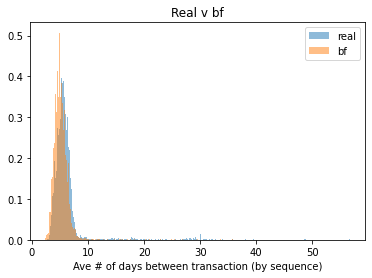

,real,bf,diff
count,4500.000000,5000.000000,500.000000
mean,5.979341,5.122403,0.856939
std,3.349927,1.550260,1.799667
min,2.593023,2.387500,0.205523
25%,4.780483,4.312500,0.467983
50%,5.528133,4.950000,0.578133
75%,6.284044,5.700000,0.584044
max,56.666667,35.775000,20.891667


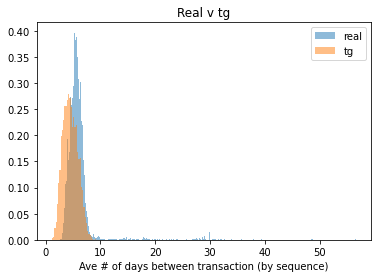

,real,tg,diff
count,4500.000000,5000.000000,500.000000
mean,5.979341,4.522203,1.457139
std,3.349927,1.338661,2.011266
min,2.593023,1.137500,1.455523
25%,4.780483,3.500000,1.280483
50%,5.528133,4.450000,1.078133
75%,6.284044,5.500000,0.784044
max,56.666667,9.187500,47.479167


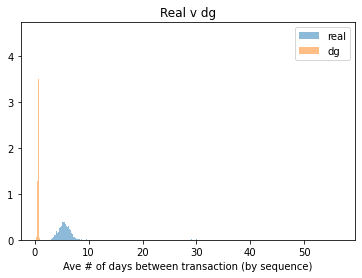

,real,dg,diff
count,4500.000000,4498.000000,2.000000
mean,5.979341,0.670400,5.308941
std,3.349927,0.100460,3.249467
min,2.593023,0.198597,2.394426
25%,4.780483,0.606787,4.173696
50%,5.528133,0.685258,4.842874
75%,6.284044,0.751305,5.532738
max,56.666667,0.895946,55.770720


In [206]:

diffs = {}

for df, lbl in zip([d_bf, d_tg, d_dg], ['bf', 'tg', 'dg']):
    
    plt.hist(d_r.ave_days_per_tr, bins='auto', label="real", alpha=0.5, density=True)
    plt.hist(df.ave_days_per_tr, bins='auto', label=lbl, alpha=0.5, density=True)
    plt.title(f"Real v {lbl}")
    plt.xlabel("Ave # of days between transaction (by sequence)")
    plt.legend()
    plt.show()
    
    d = pd.DataFrame.from_records([dict(d_r.ave_days_per_tr.describe()), dict(df.ave_days_per_tr.describe())]).T
    d.columns = ["real", lbl]
    d["diff"] = (d['real'] - d[lbl]).abs()
    display(d)
    
    diffs[lbl] = d["diff"]
    
    print("\n\n")
    

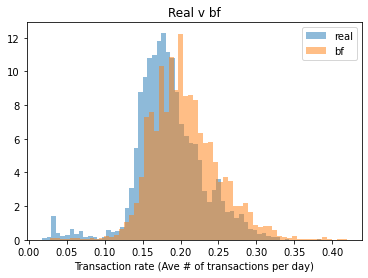

,real,bf,diff
count,4500.000000,5000.000000,500.000000
mean,5.979341,5.122403,0.856939
std,3.349927,1.550260,1.799667
min,2.593023,2.387500,0.205523
25%,4.780483,4.312500,0.467983
50%,5.528133,4.950000,0.578133
75%,6.284044,5.700000,0.584044
max,56.666667,35.775000,20.891667


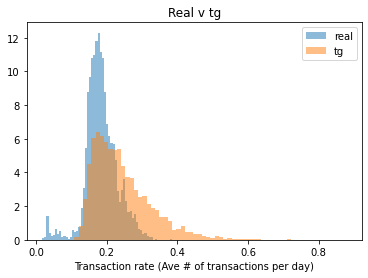

,real,tg,diff
count,4500.000000,5000.000000,500.000000
mean,5.979341,4.522203,1.457139
std,3.349927,1.338661,2.011266
min,2.593023,1.137500,1.455523
25%,4.780483,3.500000,1.280483
50%,5.528133,4.450000,1.078133
75%,6.284044,5.500000,0.784044
max,56.666667,9.187500,47.479167


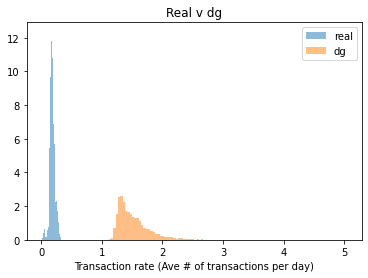

,real,dg,diff
count,4500.000000,4498.000000,2.000000
mean,5.979341,0.670400,5.308941
std,3.349927,0.100460,3.249467
min,2.593023,0.198597,2.394426
25%,4.780483,0.606787,4.173696
50%,5.528133,0.685258,4.842874
75%,6.284044,0.751305,5.532738
max,56.666667,0.895946,55.770720


In [205]:

diffs = {}

for df, lbl in zip([d_bf, d_tg, d_dg], ['bf', 'tg', 'dg']):
    
    plt.hist(1./ d_r.ave_days_per_tr, bins='auto', label="real", alpha=0.5, density=True)
    plt.hist(1. / df.ave_days_per_tr, bins='auto', label=lbl, alpha=0.5, density=True)
    plt.title(f"Real v {lbl}")
    plt.xlabel("Transaction rate (Ave # of transactions per day)")
    plt.legend()
    plt.show()
    
    d = pd.DataFrame.from_records([dict(d_r.ave_days_per_tr.describe()), dict(df.ave_days_per_tr.describe())]).T
    d.columns = ["real", lbl]
    d["diff"] = (d['real'] - d[lbl]).abs()
    display(d)
    
    diffs[lbl] = d["diff"]
    
    print("\n\n")
    

In [190]:
fgen_df.groupby("account_id").size().describe()

count    4500.000000
mean      211.436889
std        98.199428
min         1.000000
25%       129.000000
50%       203.000000
75%       295.000000
max       397.000000
dtype: float64

In [141]:
pd.DataFrame.from_dict(diffs)

,d_bf,d_tg,d_dg
count,500.000000,500.000000,0.000000
mean,0.856939,1.457139,5.309239
std,1.799667,2.011266,3.248500
min,0.205523,1.455523,2.593023
25%,0.467983,1.280483,4.173913
50%,0.578133,1.078133,4.842909
75%,0.584044,0.784044,5.532746
max,20.891667,47.479167,55.770720


In [162]:
code = real_df.tcode.unique()[2]
code 

'INTEREST CREDITED__nan__CREDIT'

In [163]:
(real_df.dtme == 0).sum() / len(real_df)

0.33083345955770976

In [164]:
real_df[real_df.tcode==code].dtme.sum()

0

In [173]:
(gen_df[gen_df.tcode==code].dtme==0).sum()/len(gen_df[gen_df.tcode==code])

0.9979218979998268

In [171]:
(gen_df[gen_df.tcode==code].dtme<60).sum()/len(gen_df)

0.173235

In [172]:
gen_df[gen_df.tcode==code].dtme<60

2         True
5         True
8         True
11        True
14        True
          ... 
399967    True
399973    True
399979    True
399988    True
399993    True
Name: dtme, Length: 69294, dtype: bool

In [176]:
real_props = []
gen_props  = []

tcode_percent_of_total = []

numer = 0.
denom = 0.

for tcode in real_df.tcode.unique():
    has_tcode = real_df.tcode == tcode
    prop_real = real_df[has_tcode].datetime.dt.is_month_end.sum() / len(real_df[has_tcode]) *100
    
    tcode_percent_of_total.append(sum(has_tcode) / len(real_df)*100)

    has_tcode = gen_df.tcode == tcode
    prop_gen = gen_df[has_tcode].date.dt.is_month_end.sum() / len(gen_df[has_tcode]) * 100
    
    
    if prop_real >= 100.:
        # print("**")
        
        numer += gen_df[has_tcode].date.dt.is_month_end.sum()
        denom += len(gen_df[has_tcode])

    print(f"For real data {prop_real:.3f}% of {tcode} occur on month end. This tcode is {tcode_percent_of_total[-1]:.2f}% of real data")
    print(f"For genr data {prop_gen:.3f}% of {tcode} occur on month end")
    
    print("\n")
    
    real_props.append(prop_real)
    gen_props.append(prop_gen)
    

For real data 1.330% of nan__CREDIT IN CASH__CREDIT occur on month end. This tcode is 14.84% of real data
For genr data 2.203% of nan__CREDIT IN CASH__CREDIT occur on month end


For real data 0.000% of nan__COLLECTION FROM ANOTHER BANK__CREDIT occur on month end. This tcode is 3.30% of real data
For genr data 0.468% of nan__COLLECTION FROM ANOTHER BANK__CREDIT occur on month end


For real data 100.000% of INTEREST CREDITED__nan__CREDIT occur on month end. This tcode is 17.34% of real data
For genr data 99.792% of INTEREST CREDITED__nan__CREDIT occur on month end


For real data 2.414% of nan__CASH WITHDRAWAL__DEBIT occur on month end. This tcode is 25.94% of real data
For genr data 5.360% of nan__CASH WITHDRAWAL__DEBIT occur on month end


For real data 100.000% of PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT occur on month end. This tcode is 14.75% of real data
For genr data 99.422% of PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT occur on month end


For real data 0.000% of HOUSEHOL

In [177]:
numer/ denom

0.9959789575523038

In [184]:
real_df[np.logical_and(real_df.raw_amount > 14.0, real_df.raw_amount < 15.0)].k_symbol.unique()

array(['INTEREST CREDITED'], dtype=object)